# Tracking quantum experiments with Amazon Braket Hybrid Jobs and Amazon SageMaker Experiments

This notebook demonstrates how you can track and manage your hybrid quantum-classical experiments using the Hybrid Jobs feature of Amazon Braket and Amazon SageMaker Experiments, a feature used by machine learning developers on AWS to organize their experiments and trials.

## Learning outcomes
* Setup of Braket Notebook server to access Amazon Sagemaker Experiments functionality
* Instantiation of an Sagemaker Experiment to track a hybrid quantum-classical experiment
* Capturing data pre-processing for experiments in Sagemaker Experiments
* Hyperparameter optimization using Braket Hybrid Jobs and Sagemaker Experiments
* Accessing and analyzing experiment results using Sagemaker Experiments


We train a variational quantum classifier (VQC) on a variant of the classic Iris data set. For demonstration purposes we use the simple [iris classification example by Pennylane](https://pennylane.ai/qml/demos/tutorial_variational_classifier.html) and the data and algorithm that is provided there and adapt the code to run on Braket Hybrid Jobs. Since we focus in this blog on the experiment tracking, we refer to the tutorial for more details on the algorithm itself.

The Notebook is structure in 5 steps:

* Step 1: Setting up the environment for experiment tracking
* Step 2: Problem example and pre-processing
* Step 3: Running the experiment and tracking it with Sagemaker Experiments
* Step 4: Evaluation of the experiment using Sagemaker Experiments.
* Step 5: Cleaning up


## Step 1: Setting up the environment for experiment tracking

The example Notebook has to run on a Braket Notebook instance with access to SageMaker. Follow these setup steps:

1. [Create an S3 bucket](https://docs.aws.amazon.com/AmazonS3/latest/userguide/creating-bucket.html) with a name that starts with amazon-braket-…. 
2. Go to the Amazon Braket console and [create a Notebook](https://docs.aws.amazon.com/braket/latest/developerguide/braket-get-started-create-notebook.html) in your preferred region. Instance size `ml.t3.medium` with standard settings is sufficient for the example. Once this Notebook instance has started it will also be accessible from the SageMaker console.
3. Select your [Braket Notebook instance in the SageMaker console](https://docs.aws.amazon.com/sagemaker/latest/dg/howitworks-access-ws.html) and select it to open up the settings.
4. Go to "Permissions and Encyrption" and click on "IAM Role ARN"
5. Click on "Add Permission" then "Create Inline Policy".
6. Copy and paste the following policy and give it a name


The permissions below need to be added to the execution role of your Amazon Braket notebook:
```
{
    "Version": "2012-10-17",
    "Statement": [
        {
            "Sid": "searchpermissions",
            "Effect": "Allow",
            "Action": [
                "sagemaker:Search"
            ],
            "Resource": "*"
        },
        {
            "Sid": "experimentpermissions",
            "Effect": "Allow",
            "Action": [
                "sagemaker:CreateExperiment",
                "sagemaker:DeleteExperiment",
                "sagemaker:DescribeExperiment",
                "sagemaker:ListExperiments",
                "sagemaker:UpdateExperiment"
            ],
            "Resource": "arn:aws:sagemaker:*:*:*amazon-braket-*"
        },
        {
            "Sid": "trialpermissions",
            "Effect": "Allow",
            "Action": [
                "sagemaker:CreateTrial",
                "sagemaker:DeleteTrial",
                "sagemaker:DescribeTrial",
                "sagemaker:ListTrials",
                "sagemaker:UpdateTrial"
            ],
            "Resource": "arn:aws:sagemaker:*:*:*amazon-braket-*"
        },
        {
            "Sid": "trialcomponentpermissions",
            "Effect": "Allow",
            "Action": [
                "sagemaker:AssociateTrialComponent",
                "sagemaker:CreateTrialComponent",
                "sagemaker:DeleteTrialComponent",
                "sagemaker:DescribeTrialComponent",
                "sagemaker:DisassociateTrialComponent",
                "sagemaker:ListTrialComponents",
                "sagemaker:UpdateTrialComponent"
            ],
            "Resource": "arn:aws:sagemaker:*:*:experiment-*"
        }
    ]
}
```
Following the [best practice](https://docs.aws.amazon.com/kms/latest/developerguide/iam-policies-best-practices.html) of not giving wildcard (`*`) permissions, we only allow to create, delete and manipulate Amazon SageMaker experiments and trials whose names start with `amazon-braket`. The only exception is the read-only `sagemaker:Search`. We have to keep these naming conventions in mind when we create these resources below.

### Requirements & imports

After you have completed the, access the Notebook instance, download the repository with this Notebook, open it in your new Braket Notebook instance with the `conda_braket` kernel and install the requirements:

In [ ]:
pip install -r requirements.txt

Run the the cells in the rest of the notebook, one after the other.

In [1]:
import os
from copy import deepcopy
from datetime import datetime

import boto3
import matplotlib.pyplot as plt
import pandas as pd
import sagemaker
from braket.aws import AwsQuantumJob, AwsSession
from braket.jobs.config import OutputDataConfig
from braket.jobs.image_uris import Framework, retrieve_image
from braket.jobs.local import LocalQuantumJob
from pennylane import numpy as np
from sagemaker import get_execution_role
from sagemaker.analytics import ExperimentAnalytics
from sagemaker.session import Session
from sklearn.model_selection import train_test_split
from smexperiments.experiment import Experiment
from smexperiments.tracker import Tracker
from smexperiments.trial import Trial
from smexperiments.trial_component import TrialComponent

from var_classifier.utils import create_features

### Get session parameters

In [2]:
sess = boto3.Session()
role = get_execution_role()

region = AwsSession().region
image_uri = retrieve_image(Framework.PL_TENSORFLOW, region)

Below we choose a local simulator as device.

In [3]:
device = "local:pennylane/lightning.qubit"

### Step 2: Problem example and pre-processing

Before we start preparing the data and training our VQC, we instantiate the overarching experiment.

In [4]:
experiment_name = (
    f"amazon-braket-my-first-vqc-experiment-{datetime.now().strftime('%Y-%m-%d-%H-%M-%S')}"
)
vqc_experiment = Experiment.create(
    experiment_name=experiment_name,
    description="Tracking my first VQC experiment using Amazon Sagemaker Experiments",
)

### Data preparation

For this simple example we run all data pre-processing and feature engineering in the notebook.

Define the S3 prefix under which you want to keep all the data generated in our experiments:

In [ ]:
s3_base_path = "amazon-braket-REMAINDER-OF-YOUR-BUCKET-NAME" # with a name that starts with "amazon-braket-"

In [6]:
base_s3_path = f"s3://{s3_base_path}/{experiment_name}"

We keep track of all inputs and outputs of the experiment in different subfolders with the following paths:

In [7]:
raw_data_path = f"{base_s3_path}/raw_data"
processed_data_path = f"{base_s3_path}/processed_data"
job_output_path = f"{base_s3_path}/jobs"

os.environ["RAW_DATA_PATH"] = raw_data_path
os.environ["PROCESSED_DATA_PATH"] = processed_data_path

Define the main parameters of data preparation:

In [8]:
# Choose the fraction of training and validation data.
# The rest will be validation data. We don't use a separate test
# set in this simple example
train_size = 0.7

# Fix a seed to ensure replicability (e.g. of train, test, val split)
seed = 42

val_size = 1 - train_size

We load the provided variant of the iris data set and select the first two columns for our feautures and the forth as the value. After that, we clean it, save it locally, and split it in training and validation set. 

In [9]:
data = np.loadtxt("data/iris_classes1and2_scaled.txt")
X, y = data[:, 0:2], data[:, 4]

In [10]:
_, id_unique = np.unique(X, return_index=True, axis=0)
X, y = X[id_unique, :], y[id_unique]

In [11]:
# Save the raw data
np.savetxt("/tmp/raw_irisdata_features.txt", X)
np.savetxt("/tmp/raw_irisdata_labels.txt", y)

In [12]:
# Split into train, val
X_train, X_val, y_train, y_val = train_test_split(
    X, y, train_size=train_size, shuffle=True, random_state=seed
)

Let's see how the training features are distributed:

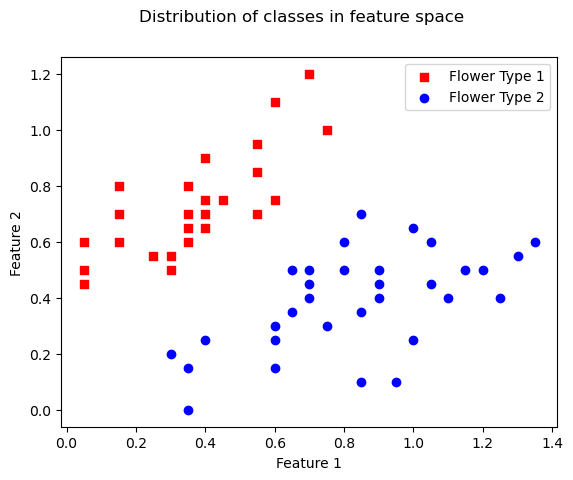

In [13]:
plt.scatter(X_train[y_train == -1, 0], X_train[y_train == -1, 1], c="red", label="Flower Type 1", marker="s")
plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], c="blue", label="Flower Type 2", marker="o")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend(loc="upper right")
plt.suptitle("Distribution of classes in feature space")
plt.show()

### Feature engineering

Feature engineering is defined in `create_features`. This function maps the data to a format that can be encoded in a qubit. Refer to the original [Pennylane example](https://pennylane.ai/qml/demos/tutorial_variational_classifier.html) and references therein for more information on this mapping.

In [14]:
feats_train = create_features(X_train)
feats_val = create_features(X_val)

Now we save the processed datasets and upload them to S3.

In [15]:
# Save in /tmp before uploading

np.savetxt("/tmp/irisdata_train_features.txt", feats_train)
np.savetxt("/tmp/irisdata_train_labels.txt", y_train)

np.savetxt("/tmp/irisdata_val_features.txt", feats_val)
np.savetxt("/tmp/irisdata_val_labels.txt", y_val)

In [ ]:
!aws s3 cp /tmp $RAW_DATA_PATH --exclude "*" --include "raw_irisdata_*.txt" --recursive
!aws s3 cp /tmp $PROCESSED_DATA_PATH --exclude "*" --include "irisdata_*.txt" --recursive

With SageMaker Experiments we can track all the parameters used in data preprocessing in this experiment and the location of the resulting datasets. This ensures full reproducability of the results and consistent tracking of all iterations.

In [17]:
with Tracker.create(
    display_name="pre-processing"
) as preproc_tracker:
    # we can log the s3 uri to the dataset we just uploaded
    preproc_tracker.log_parameters(
        {"train_size": train_size, "val_size": val_size, "seed": seed}
    )
    preproc_tracker.log_input(name="raw data", media_type="s3/uri", value=raw_data_path)
    preproc_tracker.log_output(
        name="preprocessed data", media_type="s3/uri", value=processed_data_path
    )

Note that the `Tracker` class above is not related to the `Tracker` class used for [Amazon Braket cost tracking](https://aws.amazon.com/blogs/quantum-computing/managing-the-cost-of-your-experiments-in-amazon-braket/).

## Step 3: Running the experiment and tracking it with Sagemaker Experiments

The next step is to train the VQC and perform hyperparameter optimization. Our goal is to explore how the number of layers in the VQC affects the classification performance.

For our current experiment we run trials for different values of `num_layers`. We run a Braket Hybrid Job for each selection of `num_layers`. Each run constitutes one trial of our experiment. We track all hyperparameters and the corresponding Braket Hybrid Job ARN. As in the preprocessing step, this enables us to fully reproduce our trials at a later point and investigate the artifacts that they created. We will later use this data to access all metrics and datasets of each trial.

Note that the code below will send jobs to Braket and you have to wait for the jobs to be completed before continuing with the analysis of the experiments.

In [ ]:
fixed_hyperparameters = {
    "seed": seed,
    "stepsize": 0.015,
    "num_iterations": 30,
    "batchsize": 5,
}

for num_layers in [1,2,4]:
    # Create a trial for each selection of `num_layers`.
    trial_name = f"amazon-braket-QuantumTrial-{datetime.now().strftime('%Y-%m-%d-%H-%M-%S')}"
    trial = Trial.create(
        trial_name=trial_name,
        experiment_name=vqc_experiment.experiment_name
    )

    hyperparameters = deepcopy(fixed_hyperparameters)
    hyperparameters["num_layers"] = str(num_layers)

    # Track hyperparameters
    with Tracker.create(
        display_name="hyperparameters"
    ) as hyperparameters_tracker:
        hyperparameters_tracker.log_parameters(hyperparameters)

    # Kick-off job
    print("Kicking off Trial: ", trial_name)
    job_name = "var-classifier-training-job-" + datetime.now().strftime(
        "%Y-%m-%d-%H-%M-%S"
    )
    job = AwsQuantumJob.create(
        device=device,
        source_module="var_classifier",
        job_name=job_name,
        image_uri=image_uri,
        entry_point="var_classifier.entrypoint",
        hyperparameters=hyperparameters,
        input_data=processed_data_path,
        output_data_config=OutputDataConfig(f"{job_output_path}/{job_name}"),
        wait_until_complete=False,
    )

    # Track the job_arn
    with Tracker.create(
        display_name="job-arn"
    ) as job_arn_tracker:
        job_arn_tracker.log_output("job_arn", job.arn)

    # Add trackers
    trial.add_trial_component(preproc_tracker.trial_component)
    trial.add_trial_component(hyperparameters_tracker.trial_component)
    trial.add_trial_component(job_arn_tracker.trial_component)

Kicking off Trial:  amazon-braket-QuantumTrial-2023-03-05-19-49-43


## Step 4: Evaluation of the experiment using Sagemaker Experiments.

In this section we show how you can analyze your experiments using SageMaker Experiments.

You can use the SageMaker client to search through all of our past experiments. The search can be tailored using search expressions (see [here](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/sagemaker.html#SageMaker.Client.search) for more details). We search for all experiments containing `amazon-braket-my-first-vqc-experiment` in their name.

In [ ]:
sm = sess.client("sagemaker")

In [ ]:
search_expression = {
  "Filters": [
    {
      "Name": "DisplayName",
      "Operator": "Contains",
      "Value": "amazon-braket-my-first-vqc-experiment"
    }]}

In [ ]:
sm.search(Resource="Experiment", SearchExpression=search_expression)

We can also use the higher-level functionality of `ExperimentAnalytics`. Here we use it to get more information on our last experiment in DataFrame format.

In [95]:
trial_component_analytics = ExperimentAnalytics(
    sagemaker_session=Session(sess, sm),
    experiment_name=vqc_experiment.experiment_name, # or use a different experiment that you have run in the past
)

df_exp = trial_component_analytics.dataframe()

In [ ]:
df_exp

We request information on pre-processing, which can help us recreate or debug the experiment if needed.

In [ ]:
preprocessing_cols = ["TrialComponentName", "Trials", "Experiments", "seed", "train_size", "val_size", "raw data - Value", "preprocessed data - Value"]
df_exp[df_exp.DisplayName=="pre-processing"][preprocessing_cols]

It can make sense to write custom functions that extract the most relevant information from `df_exp`. We are interested in how the performance of our algorithm changes with different values of hyperparameters. To do that we use the ARNs of the Braket Hybrid Jobs tracked with SageMaker Experiments to reload these Braket Hybrid Jobs and access this information.

In [98]:
def process_experiment_info(df_exp):
    """
    Create dataframe with key metrics of each quantum experiment

    Parameters
    ----------

    df_exp: pd.DataFrame
        DataFrame with information on quantum experiment as returned by ExperimentAnalytics

    Returns
    -------
    2-tuple:
        (df, trial_to_metrics)
    """
    # Map trial to AwsQuantumJob objects, use here that there is a one-to-one mapping between these two objects
    TRIAL_TO_JOB = {
        trials[0]: AwsQuantumJob(arn)
        for _, trials, arn in df_exp[df_exp.DisplayName == "job-arn"][
            ["Trials", "job_arn - Value"]
        ].to_records()
    }

    def _final_metrics(s):
        trial = s.Trials[0]
        job = TRIAL_TO_JOB[trial]
        res = job.result()
        del res["weights"]
        del res["bias"]
        s_res = pd.Series(res)
        s_res["Trial"] = trial
        return s_res

    # Get final metrics of each Trial
    df = df_exp[df_exp.DisplayName == "job-arn"].apply(
        lambda row: _final_metrics(row), axis=1
    )

    # Get hyperparameters of each Trial
    HYPERPARAM_COLS = [
        "batchsize",
        "num_iterations",
        "stepsize",
        "seed",
        "num_layers",
    ]

    # Create DataFrame with hyperparameters for each trial
    # Taking into account that df_exp can contain hyperparameters of
    # several experiments in the same row
    new_rows = []
    for k, row in df_exp[df_exp.DisplayName == "hyperparameters"].iterrows():
        hyperparams = row[HYPERPARAM_COLS]
        for trial in row["Trials"]:
            new_row = hyperparams.copy()
            new_row["Trial"] = trial
            new_rows.append(new_row)

    df_hyper = pd.DataFrame(new_rows)

    # Combine in one dataframe, indexed by trial
    df = (
        df.merge(df_hyper, left_on="Trial", right_on="Trial")
        .set_index("Trial")
        .sort_values(by="final_acc_val", ascending=False)
    )

    # Create dictionary with metrics
    trial_to_metrics = {
        trial: pd.DataFrame(job.metrics()) for trial, job in TRIAL_TO_JOB.items()
    }
    return df, trial_to_metrics

The dataframe `df` contains the hyperparameters and performance metrics for each trial.

In [99]:
df, trial_to_metrics = process_experiment_info(df_exp)

In [100]:
df

,final_cost_train,final_cost_val,final_acc_train,final_acc_val,batchsize,num_iterations,stepsize,seed,num_layers
Trial,,,,,,,,,
amazon-braket-QuantumTrial-2023-03-05-17-55-32,0.616925,0.556414,0.877193,0.92,5.0,30.0,0.015,42.0,4
amazon-braket-QuantumTrial-2023-03-05-17-55-29,0.749270,0.690383,0.789474,0.84,5.0,30.0,0.015,42.0,2
amazon-braket-QuantumTrial-2023-03-05-17-55-21,0.818518,0.772263,0.666667,0.72,5.0,30.0,0.015,42.0,1


We see that taking four layers yields the best final validation accuracy. However, looking only at the final validation accuracy can be deceiving. Let's dive deeper and investigate how the validation accuracy evolved with the optimization iterations within each trial.

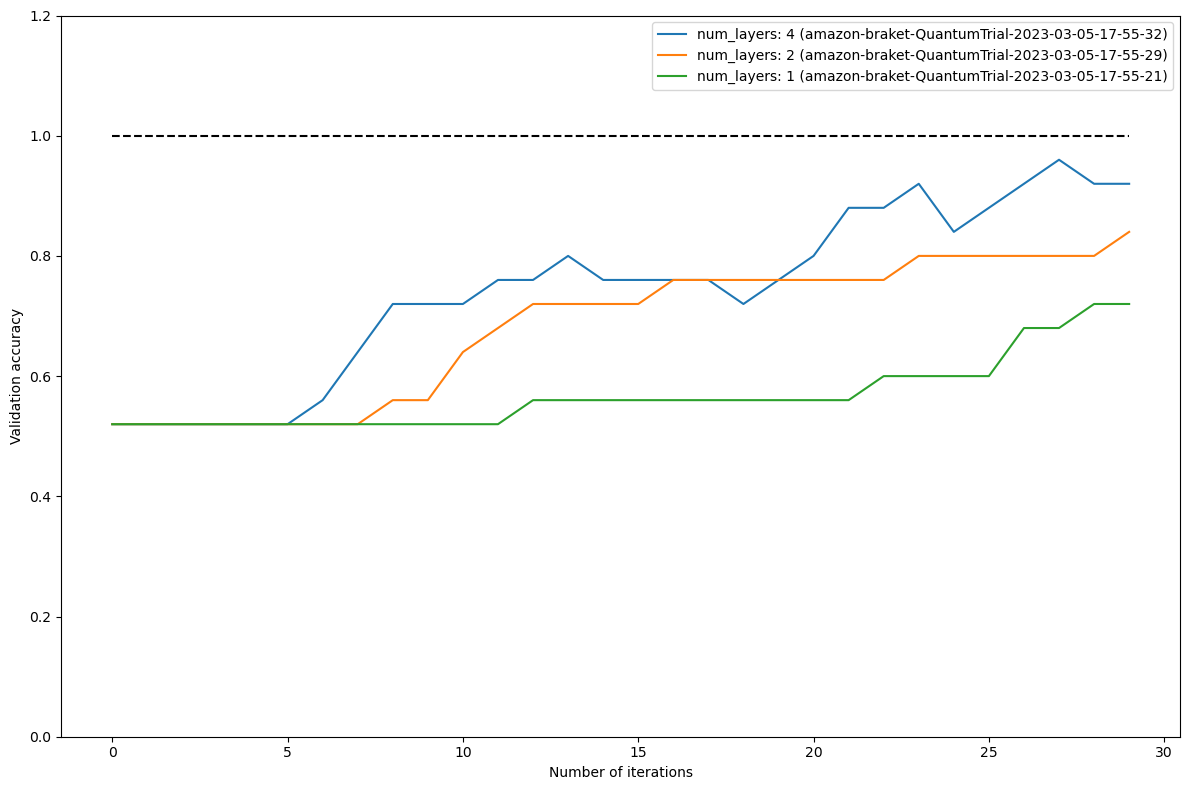

In [101]:
fig = plt.figure(figsize=(12, 8))
for trial, df_trial in trial_to_metrics.items():
    n_layers = df.loc[trial, "num_layers"]
    label = f"num_layers: {n_layers} ({trial})"
    tmp = df_trial[["iteration_number", "acc_val"]].dropna()
    plt.plot(tmp.iteration_number.values, tmp.acc_val.values, label=label)

plt.hlines(
    1,
    xmin=df_trial.iteration_number.min(),
    xmax=df_trial.iteration_number.max(),
    linestyle="--",
)
plt.ylim(0, 1.2)
plt.ylabel("Validation accuracy")
plt.xlabel("Number of iterations")
plt.legend()
plt.tight_layout()
plt.show()

We see that, with a few exceptions, the validation accuracy for four layers is the highest throughout training. This suggests that four layers is indeed the best of all our choices. However, we can also see that the validation accuracy for all choices of `num_layers` is still increasing. This suggests that we might want to run another set of trials with a larger number of iterations (`num_layers`)and compare again.

## Step 5: Cleaning up

* uncomment and run the cell below to delete all trials and components associated to the experiment created above
* delete all datasets created and stored as part of this notebook
* stop and delete your notebook instance

In [102]:
#vqc_experiment.delete_all(action="--force")